## Scenario 2: credit card dataset

**Note:** This notebook accompanies the thesis with the title: xxx by Bibian Bennink. This notebook makes use of code created by others, and this work is explicitly linked. In the thesis document all sources are properly cited too. 

###Introduction 
This notebook is used to compare Confidance Based Performance Estimation  [(CPBE)](https://nannyml.readthedocs.io/en/stable/tutorials/performance_estimation/binary_performance_estimation.html) created by NannyML and Continuous ReEvaluation [(CRE) ](https://link.springer.com/content/pdf/10.1007/s10618-019-00654-y.pdf?pdf=button) created by Grzenda, Gomes and Bifet on the first scenario: Banknotes dataset. 

The [dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) is sourced from Kaggle. The data is gathered in September 2013 by the Machine Learning Group (MLG) of Université Libre de Bruxelles and Worldline. The dataset presents transactions of European cardholders that occurred in two days. It contains 492 cases of fraud out of 284,807 transactions (0.172% of all transactions is fraud), therefore the dataset is highly unbalanced, however, simulating a real world scenario.

Due to confidentiality, since the information in the dataset is gathered from real transactions, the creators of the dataset cannot provide the original features or background information about the data. They created features: V1 till V28 by using Principle Component Analysis (PCA), with the exception of the features: ‘time’ and ‘amount’.

In [1]:
#pip installs
!pip install nannyml
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.3/222.3 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 KB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [2]:
# imports

# NannyML for CBPE
import nannyml as nml
from IPython.display import display

# General libraries
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import datetime
from scipy.io import arff

# Classifier Library
from xgboost import XGBClassifier
import collections

# Other Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from collections import Counter
import warnings
warnings.filterwarnings("ignore")

###Loading in data and gathering information about the data.

In [3]:
#Connect drive files to import data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Reading in the banknote dataset and checking if it is read in correctly
data = arff.loadarff('/content/drive/MyDrive/Research project /dataset.arff')
data = pd.DataFrame(data[0])

In [5]:
#Check the dataset values
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
#Check balance of the dataset
fraud = data['Class'].value_counts()
print("Real %: ", fraud[1]/len(data)*100)
print("Fraud %:", fraud[0]/len(data)*100)

Real %:  0.1727485630620034
Fraud %: 99.82725143693798


In [7]:
#Seperating features from the labels
y = data['Class'] #labels
X = data.drop('Class', axis=1) #features

#Stratiefied K Fold splits the data while maintaining the percentage of data points in each class.
SKF = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

for train_index, test_index in SKF.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Check if distribution is still the same
print("Train - Fraud:",np.count_nonzero(y_train==1)/len(y_train),"Train - No Fraud:",np.count_nonzero(y_train==0)/len(y_train))
print("Test - Fraud:",np.count_nonzero(y_test==1)/len(y_test),"Test - No Fraud:",np.count_nonzero(y_test==0)/len(y_test))

Train - Fraud: 0.0017282611664007303 Train - No Fraud: 0.9982717388335993
Test - Fraud: 0.001720505617977528 Test - No Fraud: 0.9982794943820225


In [8]:
# Get production data/ ground truth data ready and add ID column  
production_data = X_test.copy()
production_data['id'] = range(1, len(production_data) + 1)

ground_truth = X_test.copy()
ground_truth['class'] = y_test
ground_truth['id'] = range(1, len(ground_truth) + 1)

### Training the model

In [9]:
# XGBoost CV model
model = XGBClassifier()
kfold = StratifiedKFold(n_splits=5)
rus= RandomUnderSampler(sampling_strategy=0.10)

# use area under the precision-recall curve to show classification accuracy
scoring = 'roc_auc'

steps = [('undersampling', rus),('model', model)]
pipeline = Pipeline (steps=steps)
pipeline.fit(X_train, y_train)
results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring = scoring)

print( "AUC: %.3f (%.3f)" % (results.mean(), results.std()) )

AUC: 0.968 (0.026)


### Functions needed for the algorithms to be tested.

In [10]:
# Calculate what the start and end time of the test will be based on the number
# of datapoints in the test dataset.
def running_time(n_datapoints):

  # one point every 10 minutes
  time_needed = (n_datapoints * 10)/60
  start_time = datetime.datetime.now() - datetime.timedelta(hours=time_needed)
  
  return start_time

In [11]:
# Get an array of 0 and 1, where 0 is sending a datapoint and 1 sending 
# the ground truth.

# send_gt: Every send_gt'th datapoint will be a ground truth 
# start_gt: The first ground truth will arrive from the start_gt'th datapoint
def get_send_distribution(send_gt,start_gt, length):
  
  distribution = [0]*start_gt
  datapoint_nr = start_gt
  nr_zero = 0
  nr_one = 0

  for i in range(length*2-start_gt):
    #if nr_one>nr_zero:
    #  distribution.append(0)
    #  nr_zero+=1
    if i%send_gt == 0:
      distribution.append(1)
      nr_one += 1
    elif datapoint_nr <= length-1:
      distribution.append(0)
      datapoint_nr+=1
      nr_zero +=1
    else:
      distribution.append(1)
      nr_one+=1

  return distribution

## CBPE

##### Functions

In [12]:
# Using the CBPE algorithm by NannyML according to their tutorial: 
#https://nannyml.readthedocs.io/en/stable/tutorials/performance_estimation/binary_performance_estimation.html
def use_CBPE(reference_df,analysis_df, k): 
  
  estimator = nml.CBPE(
      y_pred_proba='predict_proba',
      y_pred='y_hat',
      y_true='class',
      timestamp_column_name='timestamp',
      metrics=['roc_auc', 'f1', 'precision', 'recall', 'accuracy','specificity'],
      chunk_size=k,
      problem_type='classification_binary',
  )

  estimator.fit(reference_df)
  
  results = estimator.estimate(analysis_df)
  display(results.filter(period='analysis').to_df())
  
  #return both the estimator itself as the df of the results
  return estimator, results.filter(period='analysis').to_df()


##### Transforming the Data

In [13]:
# Paremeters
REF_ANA_SPLIT = 2000
CHUNK = 1000

##### Testing *CBPE*

In [14]:
def run_CBPE(model, X_test, y_test, production_data, ground_truth, send_gt=20, start_gt=50):
  # Copy of the data for safekeeping
  CBPE_data = X_test.copy()
  CBPE_data['class'] = y_test

  # Two copies as from production_data rows will be dropped
  CBPE_production_data = production_data.copy() 
  CBPE_prod = CBPE_production_data.copy()

  CBPE_ground_truth = ground_truth.copy()
  CBPE_gt = CBPE_ground_truth.copy()

  # Get the distribution that determines which datapoint gets send
  CBPE_send_dist = get_send_distribution(send_gt = send_gt, start_gt = start_gt, length=len(CBPE_production_data))

  # defining the start and end time. 
  start_time = running_time(len(X_test))
  elapsed = 0

  #Dataframes that will save the predictions and timestamps. 
  reference_predictions = pd.DataFrame(columns=['y_hat','predict_proba','timestamp' ,'id'])
  analysis_predictions = pd.DataFrame(columns=['y_hat','predict_proba','timestamp','id'])
  ground_truth_time = pd.DataFrame(columns=['timestamp','id'])

  for idx, i in enumerate(CBPE_send_dist):
    # Artificial time of the datapoint
    date_time = start_time + datetime.timedelta(minutes=elapsed)
    elapsed +=5
    # if 0, then a datapoint arrived
  
    if i == 0:
      # get datapoint
      x = CBPE_production_data.head(1)
      CBPE_production_data = CBPE_production_data.tail(-1)
      x_id = str(x['id'].iloc[0])
      datapoint = x.drop('id',axis=1)
    
      # get prediction
      y_hat = model.predict(datapoint)
      probability = model.predict_proba(datapoint)

      new_row= pd.DataFrame({'y_hat': y_hat,'predict_proba': probability[0][1], 'timestamp': date_time,'id': x_id})
      if idx < REF_ANA_SPLIT:
        reference_predictions = pd.concat([new_row, reference_predictions.loc[:]]).reset_index(drop=True)
      else: analysis_predictions = pd.concat([new_row, analysis_predictions.loc[:]]).reset_index(drop=True)
  
    # if 1, then the ground truth arrived
    if i == 1:
      # get ground truth
      y = CBPE_ground_truth.head(1)
      CBPE_ground_truth = CBPE_ground_truth.tail(-1)
      y_id = str(y['id'].iloc[0])

      new_row= pd.DataFrame.from_records([{'timestamp': date_time, 'id': y_id}])
      ground_truth_time = pd.concat([new_row, ground_truth_time.loc[:]]).reset_index(drop=True)
 
  # Creating the reference dataset for the CBPE algorithm
  reference_predictions['id']= reference_predictions['id'].astype(int)
  reference_df = pd.merge(reference_predictions, CBPE_prod , on = 'id', how="inner")
  f = CBPE_gt[['id','class']]
  reference_df = pd.merge(reference_df, f , on = 'id', how="inner")
  reference_df['y_hat'] = reference_df['y_hat'].astype(int)

  # Creating the analysis dataset for the CBPE algorithm
  analysis_predictions['id']= analysis_predictions['id'].astype(int)
  analysis_df = pd.merge(analysis_predictions, CBPE_prod , on = 'id', how="inner")
  analysis_df['y_hat'] = analysis_df['y_hat'].astype(int)

  # Run the CBPE algorithm and check initial results
  cbpe, CBPE_results = use_CBPE(reference_df, analysis_df, CHUNK)
  return cbpe, CBPE_results,analysis_df, reference_df, CBPE_gt


In [15]:
cbpe, CBPE_results,analysis_df, reference_df, CBPE_gt = run_CBPE(model, X_test, y_test, production_data, ground_truth, send_gt=20, start_gt=100)

chunk                                    \
              key chunk_index start_index end_index   
0         [0:999]           0           0       999   
1     [1000:1999]           1        1000      1999   
2     [2000:2999]           2        2000      2999   
3     [3000:3999]           3        3000      3999   
4     [4000:4999]           4        4000      4999   
5     [5000:5999]           5        5000      5999   
6     [6000:6999]           6        6000      6999   
7     [7000:7999]           7        7000      7999   
8     [8000:8999]           8        8000      8999   
9     [9000:9999]           9        9000      9999   
10  [10000:10999]          10       10000     10999   
11  [11000:11999]          11       11000     11999   
12  [12000:12999]          12       12000     12999   
13  [13000:13999]          13       13000     13999   
14  [14000:14999]          14       14000     14999   
15  [15000:15999]          15       15000     15999   
16  [16000:16999]          16       16000     16999   
17  [17000:17999]          17       17000     17999   
18  [18000:18999]          18       18000     18999   
19  [19000:19999]          19       19000     19999   
20  [20000:20999]          20       20000     20999   
21  [21000:21999]          21       21000     21999   
22  [22000:22999]          22       22000     22999   
23  [23000:23999]          23       23000     23999   
24  [24000:24999]          24       24000     24999   
25  [25000:26574]          25       25000     26574   

                                                                    \
                   start_date                   end_date    period   
0  2022-08-10 21:37:18.797653 2022-08-14 13:12:18.797653  analysis   
1  2022-08-14 13:17:18.797653 2022-08-18 04:57:18.797653  analysis   
2  2022-08-18 05:02:18.797653 2022-08-21 20:37:18.797653  analysis   
3  2022-08-21 20:42:18.797653 2022-08-25 12:22:18.797653  analysis   
4  2022-08-25 12:27:18.797653 2022-08-29 04:07:18.797653  analysis   
5  2022-08-29 04:12:18.797653 2022-09-01 19:47:18.797653  analysis   
6  2022-09-01 19:52:18.797653 2022-09-05 11:32:18.797653  analysis   
7  2022-09-05 11:37:18.797653 2022-09-09 03:17:18.797653  analysis   
8  2022-09-09 03:22:18.797653 2022-09-12 18:57:18.797653  analysis   
9  2022-09-12 19:02:18.797653 2022-09-16 10:42:18.797653  analysis   
10 2022-09-16 10:47:18.797653 2022-09-20 02:22:18.797653  analysis   
11 2022-09-20 02:27:18.797653 2022-09-23 18:07:18.797653  analysis   
12 2022-09-23 18:12:18.797653 2022-09-27 09:52:18.797653  analysis   
13 2022-09-27 09:57:18.797653 2022-10-01 01:32:18.797653  analysis   
14 2022-10-01 01:37:18.797653 2022-10-04 17:17:18.797653  analysis   
15 2022-10-04 17:22:18.797653 2022-10-08 09:02:18.797653  analysis   
16 2022-10-08 09:07:18.797653 2022-10-12 00:42:18.797653  analysis   
17 2022-10-12 00:47:18.797653 2022-10-15 16:27:18.797653  analysis   
18 2022-10-15 16:32:18.797653 2022-10-19 08:07:18.797653  analysis   
19 2022-10-19 08:17:18.797653 2022-10-22 23:52:18.797653  analysis   
20 2022-10-22 23:57:18.797653 2022-10-26 15:37:18.797653  analysis   
21 2022-10-26 15:42:18.797653 2022-10-30 07:17:18.797653  analysis   
22 2022-10-30 07:22:18.797653 2022-11-02 23:02:18.797653  analysis   
23 2022-11-02 23:07:18.797653 2022-11-06 14:47:18.797653  analysis   
24 2022-11-06 14:52:18.797653 2022-11-10 06:27:18.797653  analysis   
25 2022-11-10 06:32:18.797653 2022-11-16 00:37:18.797653  analysis   

          roc_auc                     ...        accuracy        \
   sampling_error realized     value  ... lower_threshold alert   
0        0.019376      NaN  0.964385  ...        0.995276  True   
1        0.019376      NaN  0.962205  ...        0.995276  True   
2        0.019376      NaN  0.964447  ...        0.995276  True   
3        0.019376      NaN  0.961933  ...        0.995276  True   
4        0.019376      NaN  0.977425  ...        0.995276  True   
5        0.019376      NaN  0.975976  ...

##### Evaluation of CBPE

In [16]:
# Function to get the scores
def get_scores(actual, predictions):
  accuracy= accuracy_score(actual, predictions)
  f1= f1_score(actual, predictions)
  precision= precision_score(actual, predictions)
  roc_auc= roc_auc_score(actual, predictions)
  recall= recall_score(actual, predictions)
  # specificty is recall of negative class
  specificity= recall_score(actual, predictions, pos_label=0)
  return accuracy, f1, precision, roc_auc, recall, specificity

In [17]:
# Actual metrics
analysis_targets = CBPE_gt[['id','class']]
analysis_full = pd.merge(analysis_df, analysis_targets, on = 'id')
df_all = pd.concat([reference_df, analysis_full]).reset_index(drop=True)

gr = df_all['class'].to_numpy()
CBPE_predictions = df_all['y_hat'].to_numpy().astype(int)
CBPE_accuracy, CBPE_f1, CBPE_precision, CBPE_roc_auc, CBPE_recall, CBPE_specificity = get_scores(gr, CBPE_predictions)

#CBPE metrics
CBPE_pred_accuracy= CBPE_results['accuracy']['value']
CBPE_pred_f1= CBPE_results['f1']['value']
CBPE_pred_precision= CBPE_results['precision']['value']
CBPE_pred_roc_auc= CBPE_results['roc_auc']['value']
CBPE_pred_recall= CBPE_results['recall']['value']
CBPE_pred_specificity= CBPE_results['specificity']['value']

# print results
print("Predicted accuracy: ", np.mean(CBPE_pred_accuracy), "- Final accuracy:", CBPE_accuracy)
print("Predicted f1: ", np.mean(CBPE_pred_f1), "- Final f1:", CBPE_f1)
print("Predicted precision: ", np.mean(CBPE_pred_precision), "- Final precision:", CBPE_precision)
print("Predicted recall: ", np.mean(CBPE_pred_recall), "- Final recall:", CBPE_recall)
print("Predicted specificity: ", np.mean(CBPE_pred_specificity), "- Final specificity:", CBPE_specificity)
print("Predicted roc_auc: ", np.mean(CBPE_pred_roc_auc), "- Final roc_auc:", CBPE_roc_auc)

#print(CBPE_accuracy, CBPE_f1,CBPE_precision, CBPE_roc_auc, CBPE_recall, CBPE_specificity)

Predicted accuracy:  0.9958634012336405 - Final accuracy: 0.9968398876404494
Predicted f1:  0.471316847254889 - Final f1: 0.4444444444444445
Predicted precision:  0.6686067 - Final precision: 0.3185840707964602
Predicted recall:  0.39259046 - Final recall: 0.7346938775510204
Predicted specificity:  0.9988604 - Final specificity: 0.9972916886497133
Predicted roc_auc:  0.9611657032599816 - Final roc_auc: 0.8659927831003669


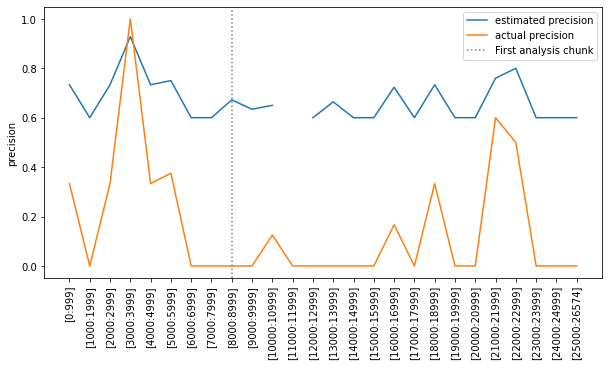

In [18]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
# add ground truth to analysis
analysis_targets = CBPE_gt[['id','class']]
analysis_full = pd.merge(analysis_df, analysis_targets, on = 'id')
df_all = pd.concat([reference_df, analysis_full]).reset_index(drop=True)
#df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])
# calculate actual ROC AUC
target_col = 'class'
pred_score_col = 'y_hat'
actual_performance = []
for idx in CBPE_results.index:
    start_date, end_date = CBPE_results.loc[idx, ('chunk', 'start_date')], CBPE_results.loc[idx, ('chunk', 'end_date')]
    sub = df_all[df_all['timestamp'].between(start_date, end_date)]
    #if len(np.unique(sub[target_col])) != 2:
    #  actual_perf = 0.75
    #else:
    actual_perf = precision_score(sub[target_col], sub[pred_score_col])
    CBPE_results.loc[idx, ('precision', 'realized')] = actual_perf
# plot
first_analysis = CBPE_results[('chunk', 'key')].values[8]
plt.figure(figsize=(10,5))
plt.plot(CBPE_results[('chunk', 'key')], CBPE_results[('precision', 'value')], label='estimated precision')
plt.plot(CBPE_results[('chunk', 'key')], CBPE_results[('precision', 'realized')], label='actual precision')
plt.xticks(rotation=90)
plt.axvline(x=first_analysis, label='First analysis chunk', linestyle=':', color='grey')
plt.ylabel('precision')
plt.legend()
plt.show()

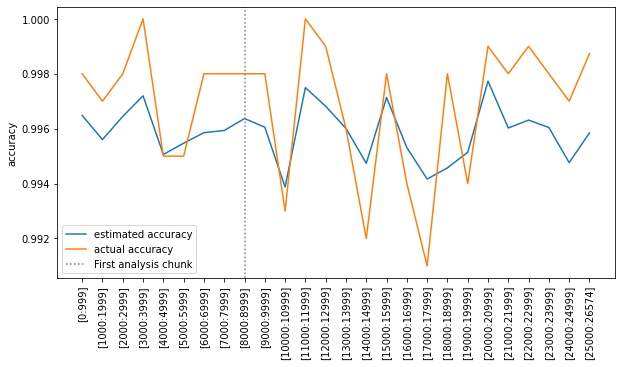

In [19]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
# add ground truth to analysis
analysis_targets = CBPE_gt[['id','class']]
analysis_full = pd.merge(analysis_df, analysis_targets, on = 'id')
df_all = pd.concat([reference_df, analysis_full]).reset_index(drop=True)
#df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])
# calculate actual ROC AUC
target_col = 'class'
pred_score_col = 'predict_proba'
actual_performance = []
for idx in CBPE_results.index:
    start_date, end_date = CBPE_results.loc[idx, ('chunk', 'start_date')], CBPE_results.loc[idx, ('chunk', 'end_date')]
    sub = df_all[df_all['timestamp'].between(start_date, end_date)]
    actual_perf = accuracy_score(sub[target_col], round(sub[pred_score_col]))
    CBPE_results.loc[idx, ('accuracy', 'realized')] = actual_perf
# plot
first_analysis = CBPE_results[('chunk', 'key')].values[8]
plt.figure(figsize=(10,5))
plt.plot(CBPE_results[('chunk', 'key')], CBPE_results[('accuracy', 'value')], label='estimated accuracy')
plt.plot(CBPE_results[('chunk', 'key')], CBPE_results[('accuracy', 'realized')], label='actual accuracy')
plt.xticks(rotation=90)
plt.axvline(x=first_analysis, label='First analysis chunk', linestyle=':', color='grey')
plt.ylabel('accuracy')
plt.legend()
plt.show()

###CRE

##### Functions

In [20]:
# Place the predicted datapoints in the right bins
def card (P, B):
  datapoint_series = P.copy()
  initial_y_hat, starttime, b1 = datapoint_series[0]
  final_y_hat, endtime, bfinal = datapoint_series[-1]
  
  # time passed since datapoint first arrived
  time_passed = endtime-starttime
  timebloks = time_passed/B
  
  # make timebloks
  timeblok_array = []
  for i in range(B):
    timeblok_array.append(starttime + (i+1)*timebloks)

  # If the point does not have an bin, place it in the correct bin.
  for indx, instance in enumerate(datapoint_series):
    y_hat, time, B = instance
    if B == -1:
      for idx, i in enumerate(timeblok_array):
        if time <= i:
          datapoint_series[indx] = (y_hat, time, idx)
    else:
      continue
  return datapoint_series


##### Testing CRE

In [33]:
def run_CRE(model, model_depth, production_data, ground_truth):
  # testing CRE

  # copy arrays and add a id column
  CRE_production_data = production_data.copy()
  CRE_ground_truth = ground_truth.copy()
  CRE_ground_truth_calc = ground_truth.copy()

  CRE_send_dist = get_send_distribution(send_gt = 20, start_gt = 50, length = len(CRE_production_data))

  #lists to store initial predictions and final predictions
  CRE_predictions = pd.DataFrame(columns=['y_hat','id'])
  CRE_final_predictions = pd.DataFrame(columns=['y_hat','id'])
  B = 5
  K= 20

  #copy of the data
  new_data=X_train.copy()
  new_data['class']=y_train

  #Dictionary of waiting instances per index:
  #[x_k,?] = instance without ground truth
  #l = (number of labeled instances)
  L = {}

  #Dictionary of lists of prediction tuples
  P = {}

  #define start and endtime
  start_time = running_time(len(X_test))
  elapsed = 0

  print(len(CRE_production_data))

  # CRE based if pseudocode from the paper by Grzenda, Gomes and Bifet
  # https://link.springer.com/content/pdf/10.1007/s10618-019-00654-y.pdf?pdf=button
  for time, i in enumerate(CRE_send_dist):
    #Model used for prediction
    date_time = start_time + datetime.timedelta(minutes=elapsed)
    elapsed +=5

    # if i == 0 it is a datapoint
    if i == 0:
      # get the datapoint and drop it from the list
      x = CRE_production_data.head(1)
      CRE_production_data = CRE_production_data.tail(-1)
      x_id = str(x['id'].iloc[0])
    
      #get data for prediction
      prod_data = x.drop('id',axis=1)
    
      #predict point and add to prediction dataframe
      y_hat = model.predict(prod_data)
      new_row= pd.DataFrame({'y_hat': y_hat, 'id': x_id})
      CRE_predictions = pd.concat([new_row,CRE_predictions.loc[:]]).reset_index(drop=True)

      L[x_id]= [(x,0)]
      P[x_id] = [(y_hat[0], date_time, 0)]

    # if i ==1 it is the ground truth
    else:
      # get the datapoint and drop it from the list
      y = CRE_ground_truth.head(1)
      CRE_ground_truth = CRE_ground_truth.tail(-1)
      y_id = str(y['id'].iloc[0])

      #Add final prediction to P
      GT_data = y.drop(['id','class'],axis=1)
    
      #predict point and add to prediction dataframe
      y_hat = model.predict(GT_data)
      new_row= pd.DataFrame({'y_hat': y_hat, 'id': y_id})
      CRE_final_predictions = pd.concat([new_row,CRE_final_predictions.loc[:]]).reset_index(drop=True)
      P[y_id].append((y['class'].iloc[0], date_time, B+1))

      P[y_id] = card(P[y_id],B)

      new_row= {'Time': y["Time"], 'V1': y["V1"], 'V2': y["V2"], 'V3': y["V3"], 'V4': y["V4"], 'V5': y["V5"], 'V6': y["V6"], 'V7': y["V7"], 'V8': y["V8"], 'V9': y["V9"],
                'V10': y["V10"], 'V11': y["V11"], 'V12': y["V12"], 'V13': y["V13"], 'V14': y["V14"], 'V15': y["V15"], 'V16': y["V16"], 'V17': y["V17"], 'V18': y["V18"],
                'V19': y["V19"], 'V20': y["V20"], 'V21': y["V21"], 'V22': y["V22"], 'V23': y["V23"], 'V24': y["V24"], 'V26': y["V26"], 'V27': y["V27"], 'V28': y["V28"],
                'Amount': y["Amount"],}
      new_data.append(new_row, ignore_index = True)
    
      # Remove from waiting dict
      popped = L.pop(y_id)
      for key in L:
        if (L[key][-1][1]%K) ==0:
          y_hat = model.predict(L[key][0][0].drop('id',axis=1))
          P[key].append((y_hat, date_time, -1))
        lst =list(L[key][-1])
        lst[1]=L[key][-1][1]+1
        L[key][-1]= tuple(lst)
    
      #train the model with the new datapoint added
      new_model = XGBClassifier()
      model = new_model.fit(new_data.drop('class',axis=1), new_data['class'])
  return CRE_predictions, CRE_final_predictions, CRE_ground_truth_calc

In [ ]:
CRE_predictions, CRE_final_predictions, CRE_ground_truth_calc = run_CRE(model, 1, production_data, ground_truth)

##### Evaluation of CRE

In [ ]:
# Function to get the scores
def get_scores(actual, predictions):
  accuracy= accuracy_score(actual, predictions)
  f1= f1_score(actual, predictions)
  precision= precision_score(actual, predictions)
  #roc_auc= roc_auc_score(actual, predictions)
  recall= recall_score(actual, predictions)
  # specificty is recall of negative class
  specificity= recall_score(actual, predictions, pos_label=0)
  return accuracy, f1, precision, recall, specificity


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score
# calculate metrics:

# Sort the predictions by id such that it matches the ground truth dataframe
CRE_predictions.id = CRE_predictions.id.astype(float)
sorted_CRE_predictions = CRE_predictions.sort_values(by=['id'])

CRE_final_predictions.id = CRE_final_predictions.id.astype(float)
sorted_CRE_final_predictions = CRE_final_predictions.sort_values(by=['id'])

# Get the array of ground truths and predictions. 
gr = CRE_ground_truth_calc['class'].to_numpy()
print(gr)
CRE_pred = sorted_CRE_predictions['y_hat'].to_numpy().astype(int)
CRE_final_pred = sorted_CRE_final_predictions['y_hat'].to_numpy().astype(int)
print(CRE_pred)


CRE_accuracy, CRE_f1, CRE_precision, CRE_recall, CRE_specificity = get_scores(gr, CRE_pred)

CRE_final_accuracy, CRE_final_f1, CRE_final_precision, CRE_final_recall, CRE_final_specificity= get_scores(gr, CRE_final_pred)

In [ ]:
print(CRE_accuracy, CRE_f1, CRE_precision, CRE_recall, CRE_specificity)
print(CRE_final_accuracy, CRE_final_f1, CRE_final_precision, CRE_final_recall, CRE_final_specificity)